# Initialization

In [1]:
import os

if os.getcwd().endswith("notebooks"):
    os.chdir("..")
    print("using project root as working dir")

using project root as working dir


In [2]:
%load_ext autoreload
%autoreload 2

In [ ]:
%load_ext tensorboard
%tensorboard --logdir runs

In [42]:
import torch

device = "cuda" if torch.cuda.is_available() else ("mps" if torch.backends.mps.is_available() else "cpu")
print(f"using {device} device")

using cuda device


# Run

In [43]:
from src.graph import gen_graph
from dataclasses import asdict
from src.args import gridsearch_args, Args
from datetime import datetime
import time
import seaborn as sns
import pandas as pd
import glob

from src.evaluator import Evaluator

In [ ]:
experiment = dict(
    key=datetime.now().strftime("%d-%m--%H-%M"),
    reps=3,
    skip_to=0,
    args=gridsearch_args(),
)
df_result = pd.DataFrame({})

run_len = len(experiment['args']) * experiment['reps']
for i, args in enumerate(experiment["args"]):
    # override args for specific test
    args.graph_type = "girg"

    # skip to beginning of specified repetition block
    if i < int(experiment['skip_to'] / experiment['reps']):
        print(f"skipping {i * experiment['reps']} to {(i + 1) * experiment['reps'] - 1}")
        continue

    # run with repetitions
    for rep in range(experiment["reps"]):
        run_index = i * experiment['reps'] + rep
        print(f"running evaluator {run_index}/{run_len}")

        graph, dim = gen_graph(args)
        evaluator = Evaluator(
            graph=graph,
            dim=dim,
            args=args,
            writer_log_dir=f"runs/{experiment['key']}/s{args.epoch_graph_size}-a{args.epoch_graph_alpha}-b{args.epoch_graph_boredom_pth}-l{args.layers}xs{args.layer_size}--{rep}",
            device=device
        )
        start_time = time.time()
        evaluator.train(
            optimizer=torch.optim.Adam(evaluator.net.parameters(), lr=1e-3),
            save_fig=False
        )
        end_time = time.time()
        test_loss, test_ap, test_f1 = evaluator.test(
            epoch=args.epochs,
            save_fig=True
        )

        df_result = pd.concat([
            df_result,
            pd.Series({
                # run meta
                "run_index": run_index,
                "run_time": end_time - start_time,
                # run results
                "loss": test_loss,
                "ap": test_ap,
                "f1": test_f1,
                # run args
                **asdict(args),
            }).to_frame().T
        ], ignore_index=True)

    # save results just in case the run fails mid run
    df_result.to_csv(f"{experiment['key']}.csv.zip", index=False, compression=dict(method='zip', archive_name=f"{experiment['key']}.csv"))

# Results

   epoch_graph_size  epoch_graph_alpha        ap
0               100                0.0  0.980308


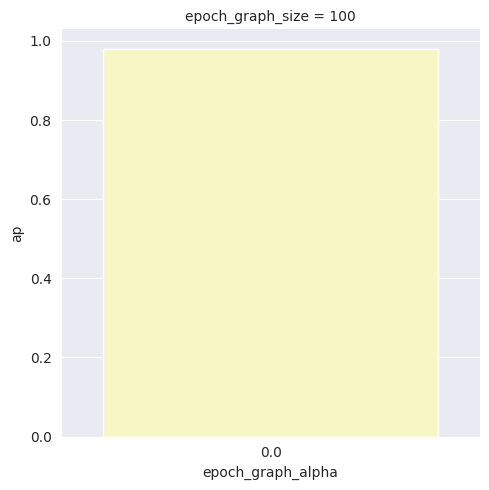

In [56]:
# mean score (bars)
df_result_mean_ap = df_result.groupby(["epoch_graph_size", "epoch_graph_alpha"], as_index=False)["ap"].mean().sort_values(by=['ap'])
print(df_result_mean_ap)

sns.catplot(
    data=df_result_mean_ap,
    col="epoch_graph_size",
    x="epoch_graph_alpha",
    y="ap",
    palette="Spectral",
    kind = "bar"
)

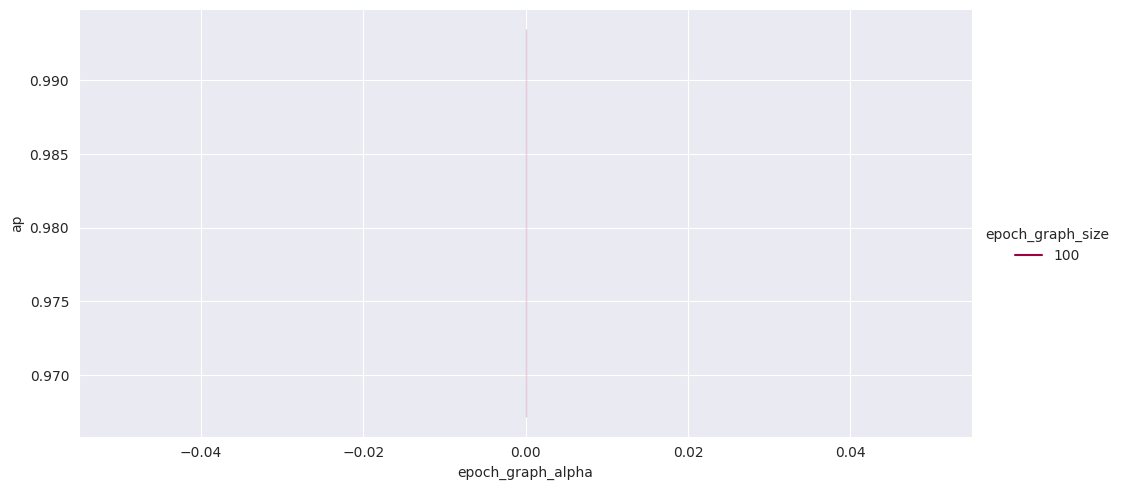

In [57]:
# score per epoch graph size and alpha (line with std)
sns.relplot(
    data=df_result, kind="line",
    hue="epoch_graph_size",
    x="epoch_graph_alpha",
    y="ap",
    errorbar="sd",
    palette="Spectral",
    aspect=2,
)

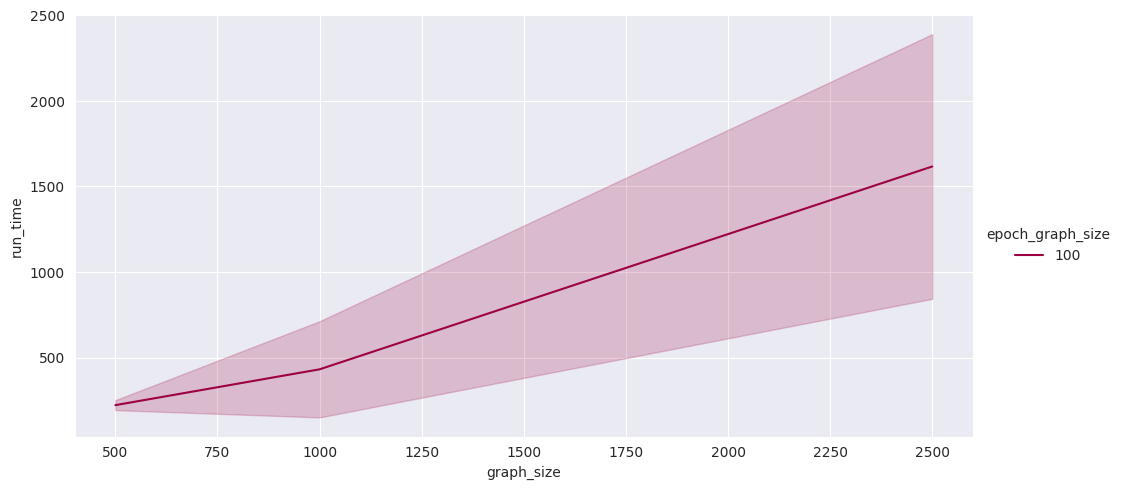

In [59]:
# run time per graph and epoch graph size (line with std)
sns.relplot(
    data=df_result, kind="line",
    hue="epoch_graph_size",
    x="graph_size",
    y="run_time",
    errorbar="sd",
    palette="Spectral",
    aspect=2,
)

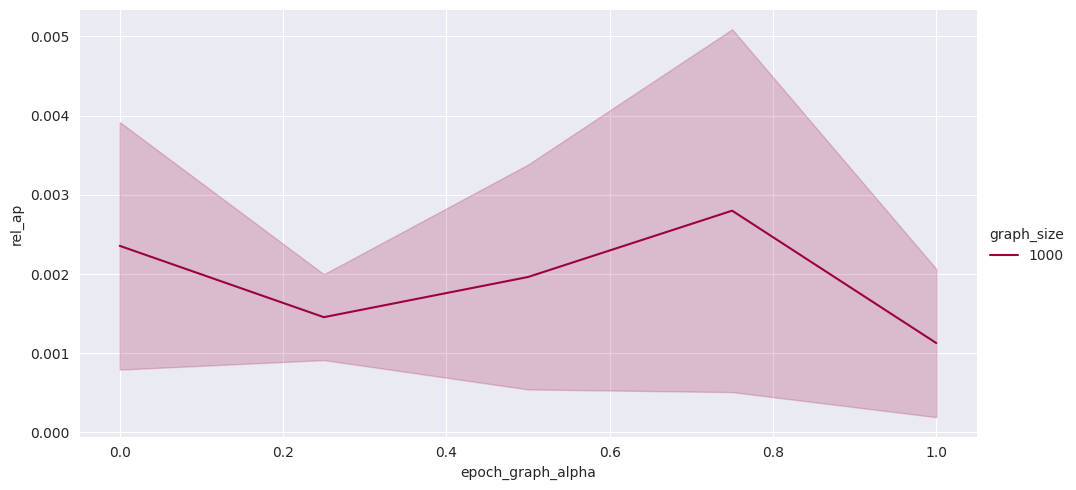

In [53]:
# score per time
df_result["rel_ap"] = df_result['ap'] / df_result['run_time']
sns.relplot(
    data=df_result, kind="line",
    hue="graph_size",
    x="epoch_graph_alpha",
    y="rel_ap",
    errorbar="sd",
    palette="Spectral",
    aspect=2,
)

# Load folder

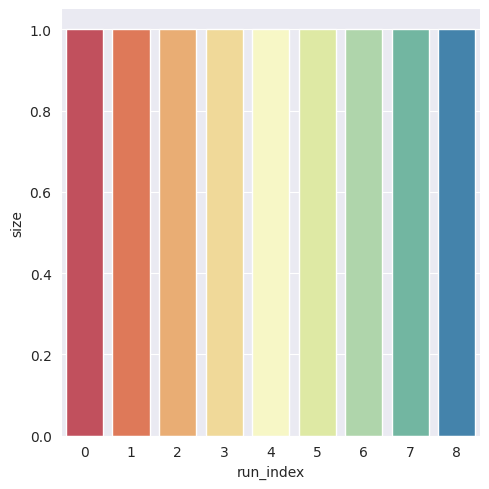

In [55]:
path = "./results/graph-size"
all_files = glob.glob(os.path.join(path, "*.csv.zip"))
df = pd.concat((pd.read_csv(f) for f in all_files), ignore_index=True)
df_result = df
#df_result.to_csv(os.path.join(path, "complete.csv.zip"), index=False, compression=dict(method='zip', archive_name=f"complete.csv"))

df_result_count = df_result.groupby(["run_index"], as_index=False)["run_index"].size()
sns.catplot(
    data=df_result_count,
    x="run_index",
    y="size",
    palette="Spectral",
    kind="bar"
)